In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
base=automap_base()

# reflect the tables
base.prepare(engine, reflect= True)

In [8]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement= base.classes.measurement
station= base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session= Session(engine)

# Exploratory Climate Analysis

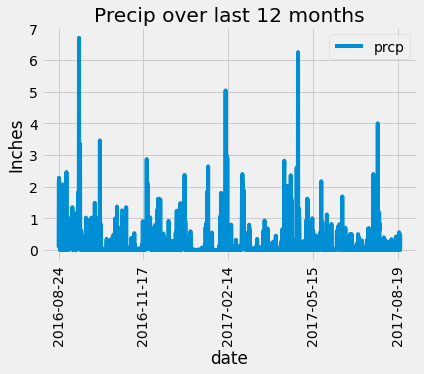

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

year= session.query(measurement).order_by(measurement.date.desc()).limit(1)

for date in year:
    most_recent= date.date
    
most_recent=dt.datetime.strptime(most_recent, "%Y-%m-%d")

#most_recent

# Calculate the date 1 year ago from the last data point in the database

one_year= most_recent- dt.timedelta(days=365)

#one_year

# Perform a query to retrieve the data and precipitation scores
recent_precip= session.query(measurement.date, measurement.prcp). filter(measurement.date >= one_year).order_by(measurement.date).all()

#recent_precip

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df= pd.DataFrame(recent_precip).dropna()
#precip_df.head

#Set index to date

date=precip_df.set_index([precip_df['date']])
#date

# Use Pandas Plotting with Matplotlib to plot the data

date.plot()
plt.title("Precip over last 12 months")
plt.xticks(rotation= 90)
plt.ylabel("Inches")
plt.show()



In [39]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [42]:
# Design a query to show how many stations are available in this dataset?
stations=session.query(measurement.station).distinct().count()

stations

9

In [46]:
# What are the most active stations? (i.e. what stations have the most rows)?
count= (session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
        order_by(func.count(measurement.station).desc()).all())

count
# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = count[0][0]
print(most_active)

#query for highest temperature
highesttemp = (session.query(measurement.tobs).\
               filter(measurement.station == most_active).order_by(measurement.tobs.desc()) .first())
highestTemp = highesttemp[0]
print(highesttemp)

#query for lowest temperature
lowesttemp = (session.query(measurement.tobs).\
              filter(measurement.station == most_active).order_by(measurement.tobs.asc()).first())
lowestemp = lowesttemp[0]
print(lowesttemp)

#query for average temperature
avgtemp = (session.query(func.avg(measurement.tobs)).\
           filter(measurement.station == most_active))
avgtemp = '{0:.3}'.format(avgtemp[0][0])
print(avgtemp)

USC00519281
(85.0,)
(54.0,)
71.7


<function matplotlib.pyplot.show(*args, **kw)>

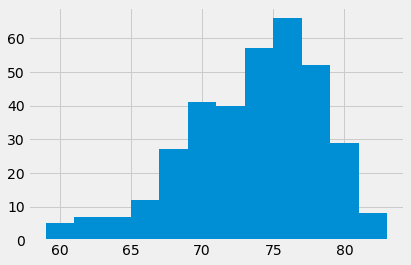

In [58]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_obs= session.query(measurement.tobs).\
                filter(measurement.station== most_active).\
                filter(measurement.date >= one_year). order_by(measurement.date.desc()).all()

x= [x[0] for x in most_obs]

plt.hist(x, bins=12)
plt.ylabel('Observations')
plt.show

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
